ERROR: Could not find a version that satisfies the requirement sklearnex (from versions: none)
ERROR: No matching distribution found for sklearnex


In [31]:
import os
import time
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import *
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier

In [6]:
path = os.getcwd() + "/new_fft_npa11/"
path

'C:\\Users\\traan\\AIL Beesound Code\\15_8_23/new_fft_npa11/'

In [8]:
TRAINING_DIR = path+"/train"
VALIDATION_DIR = path + "/val"
TEST_DIR = path + "/test"

In [9]:
def data_loader(path):
    X = []
    y = []
    for folder in os.listdir(path):
        for file in os.listdir(os.path.join(path, folder)):
            feature = np.load(os.path.join(path, folder, file))
            label = folder
            X += feature.tolist()
            y += [label]*feature.shape[0]
    return X, y

In [13]:
X_train, y_train = data_loader(TRAINING_DIR)
X_val, y_val = data_loader(VALIDATION_DIR)
X_test, y_test = data_loader(TEST_DIR)

In [14]:
X_train = np.array(X_train)
X_train = X_train.reshape(X_train.shape[0], -1)

X_val = np.array(X_val)
X_val = X_val.reshape(X_val.shape[0], -1)

X_test = np.array(X_test)
X_test = X_test.reshape(X_test.shape[0], -1)

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

print("Shape of X_train: {}".format(X_train.shape))
print("Shape of X_val: {}".format(X_val.shape))
print("Shape of X_test: {}".format(X_test.shape))
print("Shape of y_train: {}".format(y_train.shape))
print("Shape of y_val: {}".format(y_val.shape))
print("Shape of y_test: {}".format(y_test.shape))

Shape of X_train: (14000, 128)
Shape of X_val: (2000, 128)
Shape of X_test: (4000, 128)
Shape of y_train: (14000,)
Shape of y_val: (2000,)
Shape of y_test: (4000,)


In [15]:
X_test = np.vstack((X_test, X_val))
y_test = np.hstack((y_test, y_val))
y_train = y_train.reshape((y_train.shape[0], 1))
y_test = y_test.reshape((y_test.shape[0], 1))

print("Shape of X_train: {}".format(X_train.shape))
print("Shape of X_test: {}".format(X_test.shape))
print("Shape of y_train: {}".format(y_train.shape))
print("Shape of y_test: {}".format(y_test.shape))

Shape of X_train: (14000, 128)
Shape of X_test: (6000, 128)
Shape of y_train: (14000, 1)
Shape of y_test: (6000, 1)


In [16]:
X_train = X_train.astype('float')
X_test = X_test.astype('float')

In [17]:
shuffle_index = np.random.permutation(len(X_train))
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]
shuffle_index = np.random.permutation(len(X_test))
X_test, y_test = X_test[shuffle_index], y_test[shuffle_index]

In [20]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
np.unique(y_test)

C:\Users\traan\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\traan\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


array([0, 1])

In [22]:
std_scaler = StandardScaler()
X_train = std_scaler.fit_transform(X_train)
X_test = std_scaler.transform(X_test)
print(X_train.shape)

(14000, 128)


In [34]:
SEED = 1337
estimator = [
    ('RF', RandomForestClassifier(random_state=SEED)),
    ('ET', ExtraTreesClassifier(random_state=SEED)),
    ('XGB', XGBClassifier(random_state=SEED))
]

clf = StackingClassifier(estimators=estimator, final_estimator=RandomForestClassifier(random_state=SEED), cv=5)

time_start = time.time()
clf.fit(X_train, y_train)
time_end = time.time()
training_time = time_end - time_start
print("Training time: {:.2f} seconds".format(training_time))

Training time: 201.64 seconds


In [35]:
y_pred = clf.predict(X_test)

In [36]:
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
classification_report = classification_report(y_test, y_pred)

In [37]:
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(cm)
print("Classification Report:")
print(classification_report)
print("Training time: {:.2f} seconds".format(training_time))

Accuracy: 0.9155
Confusion Matrix:
[[2766  234]
 [ 273 2727]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.92      0.92      3000
           1       0.92      0.91      0.91      3000

    accuracy                           0.92      6000
   macro avg       0.92      0.92      0.92      6000
weighted avg       0.92      0.92      0.92      6000

Training time: 201.64 seconds


In [38]:
def plot_confusion_matrix(cm, title='FFT 1D Stack Classifier ML Confusion Matrix'):
    df_cm = pd.DataFrame(cm, index = [i for i in ['Queen', 'Queenless']],
                    columns = [i for i in ['Queen', 'Queenless']])
    df_cm_normed = df_cm/df_cm.sum()
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=True, fmt="", )
    plt.title(title)
    plt.savefig("FFT 1D with Stack Classifier ML Confusion Matrix.png")
    plt.show()

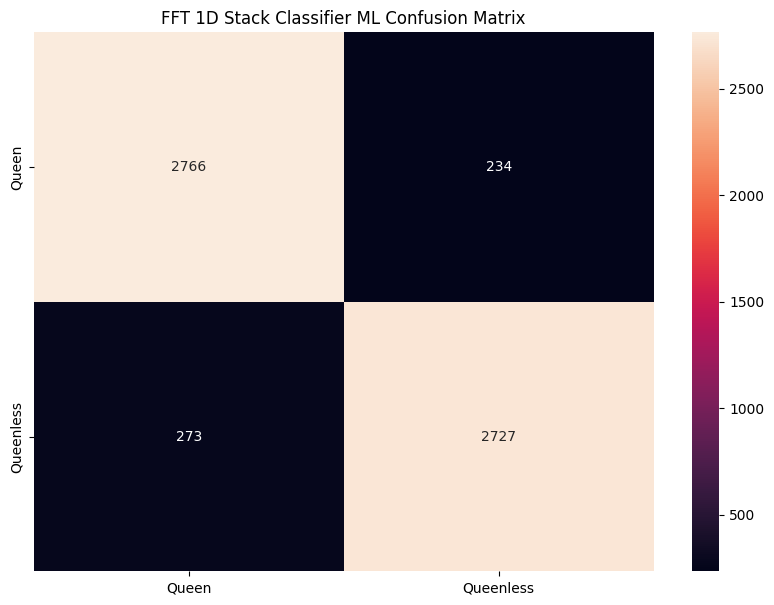

In [39]:
plot_confusion_matrix(cm)

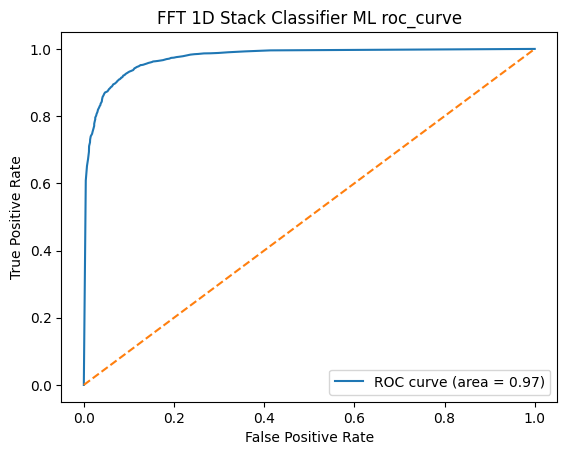

In [41]:
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])

auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label="ROC curve (area = {0:.2f})".format(auc))
plt.plot([0, 1], [0, 1], linestyle="dashed")
plt.title("FFT 1D Stack Classifier ML roc_curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.savefig("FFT 1D with Stack Classifier ML roc_curve.png")
plt.show()

In [42]:
import pickle

with open('FFT 1D StackingClassifier.pkl', 'wb') as f:
    pickle.dump(clf, f)